In [1]:
import pandas as pd
import numpy as np
import os, glob
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')
# 解决中文显示问题
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

# 读取数据

In [2]:
def GetData(field_name):
    Files = glob.glob(r'D:\07-科技项目\02  大数据-中软\现场数据标准化运行代码\%s\导出数据\*\*.csv'%(field_name))
    df_list = []
    for file in Files:
        df = pd.read_csv(file, parse_dates=['时间','dt'])
        df_list.append(df)
    DF = pd.concat(df_list)
    
    ############ rename ############
    ###### 参数确定 ######
    if field_name == '蒙天（金风）':
        tur_type='直驱'
    else:
        tur_type='双馈'

    var_info = pd.read_csv(r'E:\甘肃、新疆、张北区域数据测点整理\测点对应映射表.csv')
    var_data = var_info[[tur_type, field_name]].dropna().copy()
    var_dict = dict(zip(var_data[field_name], var_data[tur_type]))
    
    ###### rename ######
    temp_use_cols = [col for col in var_dict.keys() if col in DF.columns]
    DATA=DF[['deviceid','时间']+temp_use_cols].rename(columns=var_dict)
    return DATA    

In [17]:
field_name = '安马三（马鬃山二期）'
# field_name = '昌三'
DATA=GetData(field_name)

In [18]:
DATA.columns

Index(['deviceid', '时间', '叶轮转速1', '主轴承温度1', '叶片1实际桨距角', '叶片2实际桨距角', '叶片3实际桨距角',
       '叶片桨距角设定值', '叶片1变桨电机温度', '叶片2变桨电机温度', '叶片3变桨电机温度', '叶片1变桨电池（电容）温度',
       '叶片2变桨电池（电容）温度', '叶片3变桨电池（电容）温度', '齿轮箱油池温度', '齿轮箱电泵压力', '齿轮箱油泵低速启停反馈',
       '齿轮箱高速轴驱动端轴承温度', '齿轮箱高速轴非驱动端轴承温度', '发电机滑环室温度', '发电机驱动端轴承温度1',
       '发电机非驱动端轴承温度1', '网侧L1相电压', '网侧L2相电压', '网侧L3相电压', '平均线电压', '网侧L1相电流',
       '网侧L2相电流', '网侧L3相电流', '平均线电流', '电网频率', '变频器1散热系统入口水/空气温度', '实际扭矩',
       '扭矩设定值', '风速1', '地理风向1', '机舱外环境温度', '机舱内温度', '风向夹角1', '偏航扭缆角度',
       '液压系统压力', '网侧有功功率', '网侧无功功率', '功率因数', '叶片结冰状态', '高速刹车状态反馈'],
      dtype='object')

# 数据下钻

In [5]:
def bin_func(data):
    start = int(np.floor(data.min()))-1
    end = int(np.ceil(data.max()))+1
    step = int((end-start)/100)
    if step < 1:
        step = 0.5
    bins = np.arange(start, end+step, step)
    temp = pd.cut(data, bins)
    return temp

In [6]:
def quantile_diff(data, data_ref):    
    quantile_list = np.arange(0.01, 1, 0.01)
    ### 数据归一化到0~1之间
    xmin=np.quantile(data_ref,0.01)
    xmax=np.quantile(data_ref,0.99)
    
    df=(data-xmin)/(xmax-xmin)
    df_ref=(data_ref-xmin)/(xmax-xmin)    
    
    res = df.quantile(quantile_list)
    res_ref = df_ref.quantile(quantile_list)
    result = 100*(res-res_ref).abs().mean()    #### 计算结果是偏离程度的百分比
    return result

In [12]:
def myfunc(DF,deviceid,col):
    ######################### 用两种方法下钻排查 #########################
    gDF = DF[['时间','deviceid', col]].copy()
    gdf = gDF[gDF['deviceid']==deviceid].copy()
    nn=gdf[col].nunique()
    xmin=gDF[col].min()
    xmax=gDF[col].max()

    ######################## 原始数据 ########################
    #### 散点图
    plt.figure(figsize=(15,2))
    plt.plot(gdf['时间'], gdf[col],'.')
    plt.title('散点图')
    plt.show()
    plt.close()
    
    #### 直方图
    plt.figure(figsize=(15,2))
    _=plt.hist(gDF[col],range=(xmin,xmax),bins=100)
    _=plt.hist(gdf[col],range=(xmin,xmax),bins=100,color='r')
    plt.title('全部机组直方图')
    plt.show()
    plt.close()
    
    #### 直方图
    plt.figure(figsize=(15,2))
    _=plt.hist(gdf[col],range=(xmin,xmax),bins=100)
    plt.title('单台机组直方图')
    plt.show()
    plt.close()
    

    if nn>500:
        ####################### 直方图分布差 ########################
        temp1=gDF.copy()
        temp1['bin'] = bin_func(temp1[col])
        temp1['bin_mean'] = temp1['bin'].map(lambda x: int(np.floor(np.mean(eval(str(x)[1:-1])))))

        ## 统计总分布
        temp1['all_count'] = temp1[col].count()
        temp1['bin_all_count'] = temp1.groupby('bin')[col].transform('count')
        temp1['bin_all_percent'] = 100*temp1['bin_all_count']/temp1['all_count']

        ## 单个设备分布
        gtemp1=temp1[temp1['deviceid']==deviceid].copy()
        gtemp1['group_count'] = gtemp1[col].count()
        gtemp1['bin_group_count'] = gtemp1.groupby('bin')[col].transform('count')
        gtemp1['bin_group_percent'] = 100*gtemp1['bin_group_count']/gtemp1['group_count']
        gtemp1['group_result'] = (gtemp1['bin_group_percent'] - gtemp1['bin_all_percent']).abs()

        print('*'*50)
        #### 直方图
        plt.figure(figsize=(15,2))
        plt.plot(gtemp1['bin_mean'], gtemp1['bin_group_percent'],'r.',label='单台机组分布占比')
        plt.plot(gtemp1['bin_mean'], gtemp1['bin_all_percent'],'g.',label='整体机组分布占比')
        plt.legend()
        plt.title('机组分布占比')
        plt.show()
        plt.close()
        print('直方图结果：',gtemp1['group_result'].mean())

    ######################## Q-Q图分布差 ########################
    quantile_list = np.arange(0.01, 1, 0.01)
    qt = DF[col].quantile(quantile_list)
    gqt = gdf[col].quantile(quantile_list)

    plt.figure(figsize=(15,2))
    plt.plot(qt, qt,'r-')
    plt.plot(qt, gqt,'.')
    plt.title('Q-Q图')
    plt.show()
    plt.close()

    result_value = quantile_diff(gdf[col].dropna(), DF[col].dropna())
    print('Q-Q图结果：',result_value)


************************************************** B15-5206F **************************************************


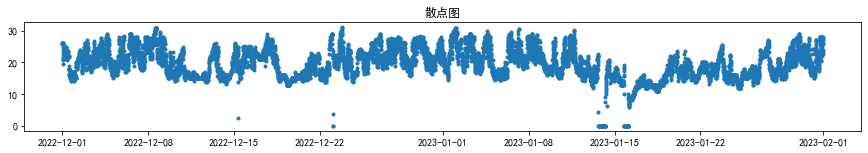

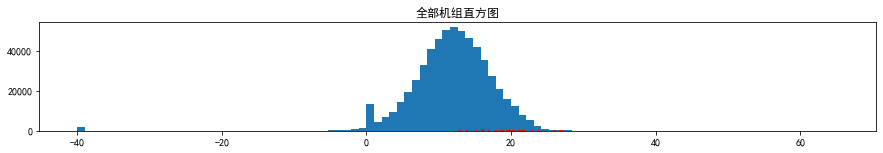

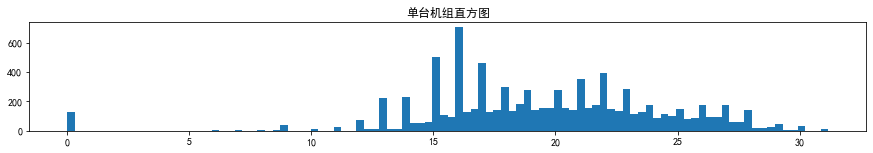

**************************************************


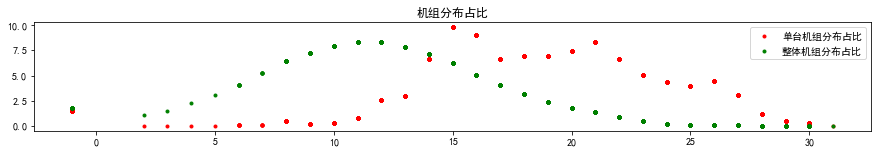

直方图结果： 4.1696235601790494


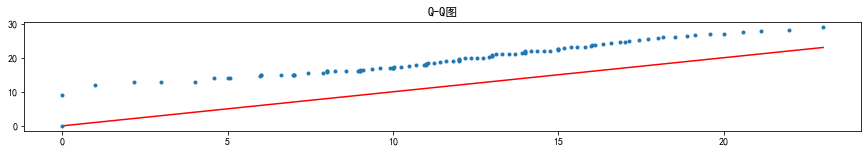

Q-Q图结果： 32.97029073342115


In [8]:
col='叶片1变桨电池（电容）温度'
device_list=['B15-5206F']  ### 最好不超过5台
for deviceid in device_list:
    print('\n%s %s %s'%('*'*50, deviceid, '*'*50))
    myfunc(DATA,deviceid=deviceid,col=col)

In [ ]:
device_list=['JN112-B409','JN091-B204']

In [96]:
[col for col in DATA.columns if '变桨电机' in col]

['叶片1变桨电机温度', '叶片2变桨电机温度', '叶片3变桨电机温度']

In [101]:
temp = DATA[DATA['deviceid']=='JN091-B204'].copy()
temp.max()

deviceid                     JN091-B204
时间                  2023-01-31 23:50:00
叶轮转速1                           29.1055
主轴承温度1                          20.8999
主轴承温度2                         26.52795
叶片平均桨距角                       137.34165
叶片桨距角设定值                       137.6263
叶片1变桨电机温度                       90.7033
叶片2变桨电机温度                         215.0
叶片3变桨电机温度                         97.57
轮毂温度                               17.0
齿轮箱油池温度                         59.9343
齿轮箱入口油压                          4.7064
齿轮箱入口油温                         57.9671
齿轮箱电泵压力                          11.912
齿轮箱高速轴驱动端轴承温度                    57.874
齿轮箱高速轴非驱动端轴承温度                  74.9022
发电机滑环室温度                            0.0
发电机驱动端轴承温度1                     59.1242
发电机非驱动端轴承温度1                    50.5956
平均线电压                          708.9645
平均线电流                           1310.17
电网频率                            50.0292
变频器2散热系统入口水/空气温度                19.5675
实际扭矩                          12376.825


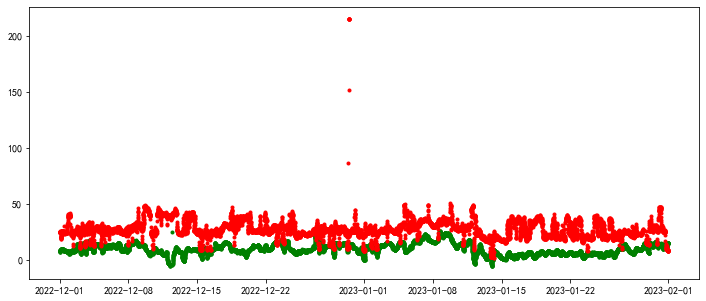

In [98]:
df1=DATA[DATA['deviceid']=='JN112-B409'][['时间',col]].copy()
df2=DATA[DATA['deviceid']=='JN091-B204'][['时间',col]].copy()
plt.figure(figsize=(12,5))
plt.plot(df1['时间'],df1[col],'g.')
plt.plot(df2['时间'],df2[col],'r.')


************************************************** JN112-B409 **************************************************


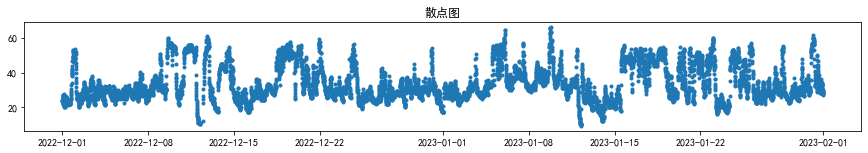

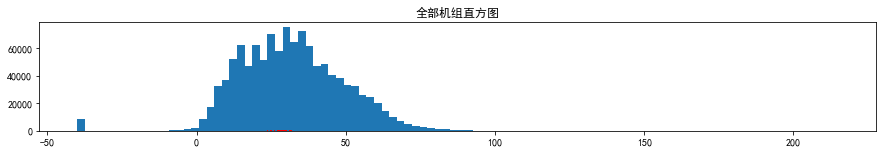

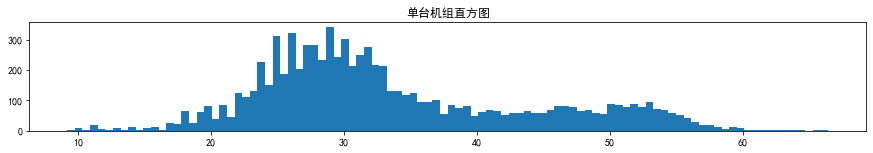

**************************************************


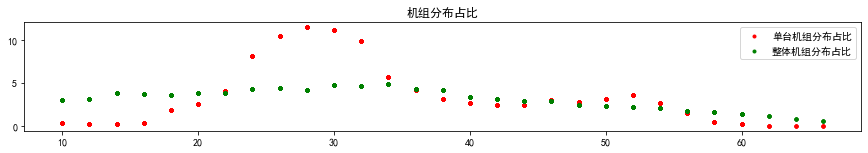

直方图结果： 3.372269500595407


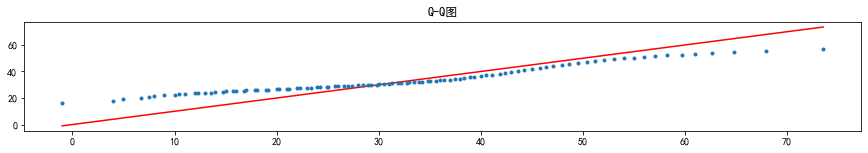

Q-Q图结果： 7.375120827475044

************************************************** JN091-B204 **************************************************


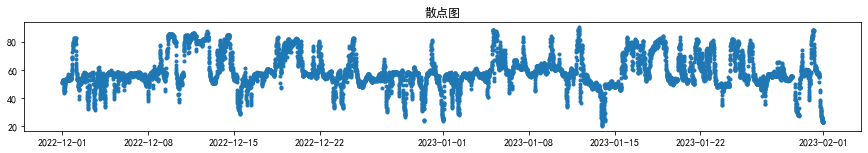

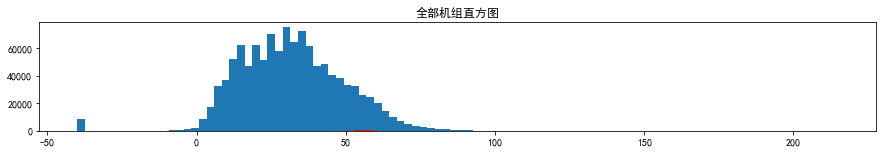

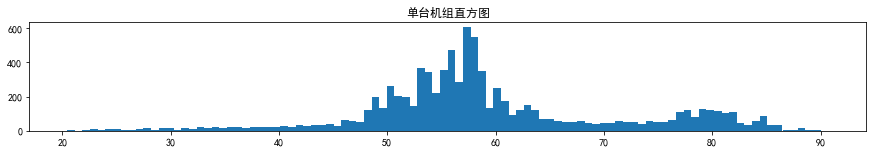

**************************************************


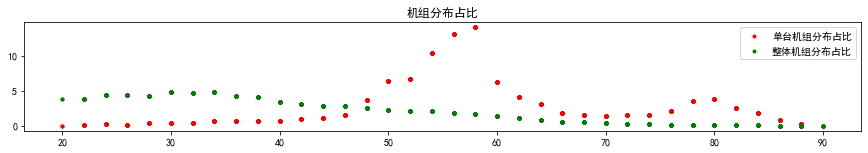

直方图结果： 5.989681615784601


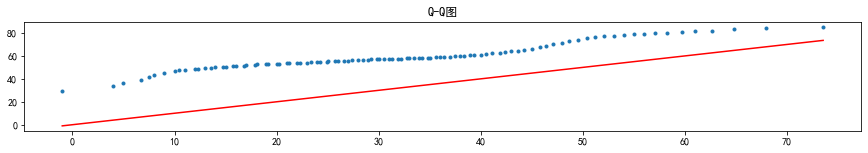

Q-Q图结果： 36.745807689772136


In [102]:
col='叶片1变桨电机温度'
device_list=['JN112-B409', 'JN091-B204']  ### 最好不超过5台
for deviceid in device_list:
    print('\n%s %s %s'%('*'*50, deviceid, '*'*50))
    myfunc(DATA,deviceid=deviceid,col=col)


************************************************** JN097-B310 **************************************************


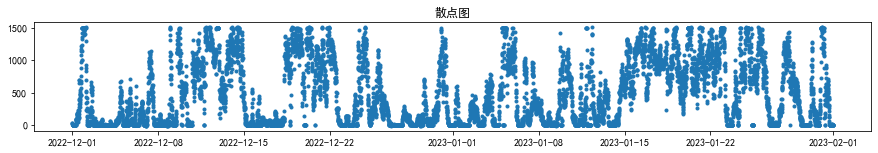

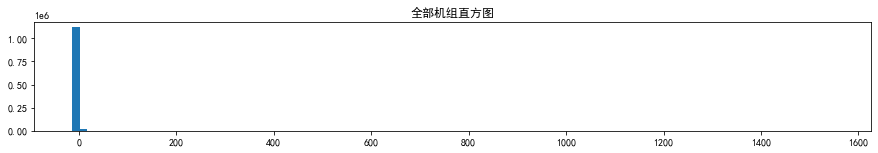

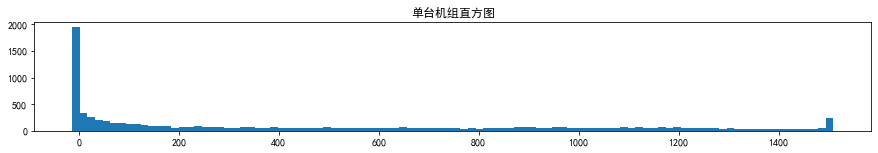

**************************************************


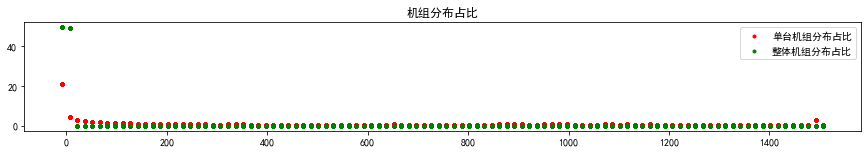

直方图结果： 8.76782760067668


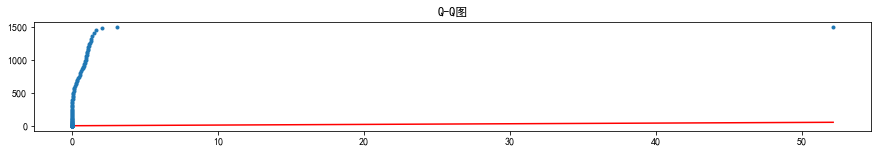

Q-Q图结果： 908.3435540455677

************************************************** JN095-B312 **************************************************


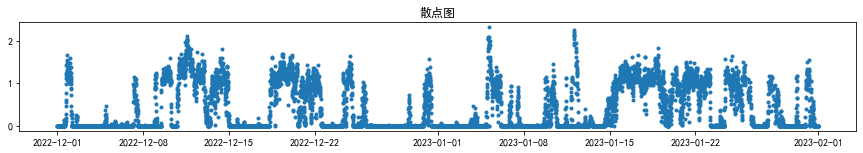

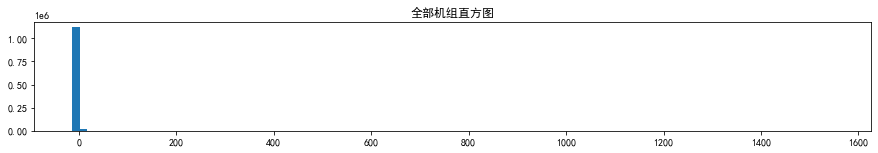

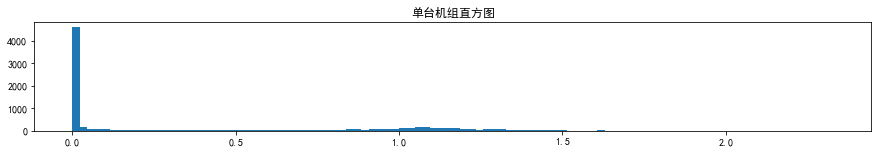

**************************************************


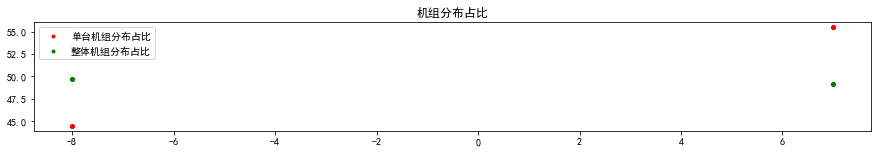

直方图结果： 5.8426074698204955


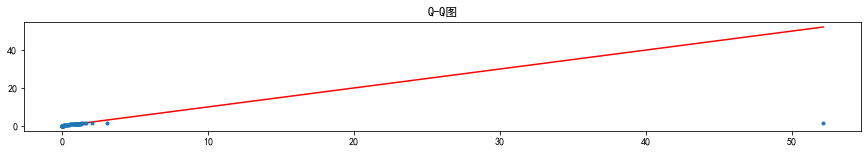

Q-Q图结果： 1.1316444688096647


In [108]:
col='机舱侧向振动'
device_list=['JN097-B310','JN095-B312']  ### 最好不超过5台
for deviceid in device_list:
    print('\n%s %s %s'%('*'*50, deviceid, '*'*50))
    myfunc(DATA,deviceid=deviceid,col=col)

In [16]:
col='机舱侧向振动'
device_list=['JN095-B312']  ### 最好不超过5台
for deviceid in device_list:
    print('\n%s %s %s'%('*'*50, deviceid, '*'*50))
    myfunc(DATA[DATA[col]<10],deviceid=deviceid,col=col)


************************************************** JN095-B312 **************************************************


KeyError: '机舱侧向振动'


************************************************** JN125-B501 **************************************************


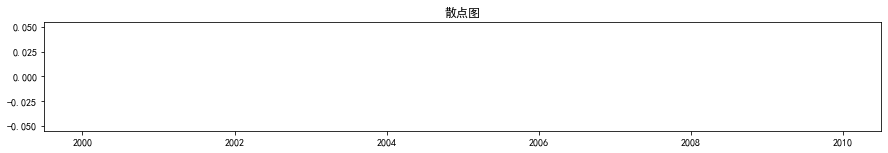

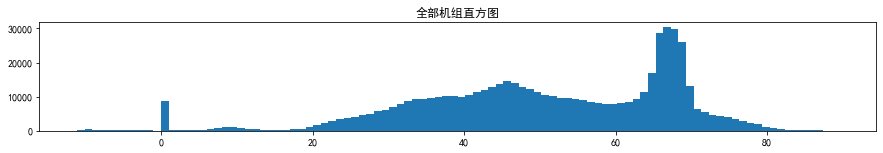

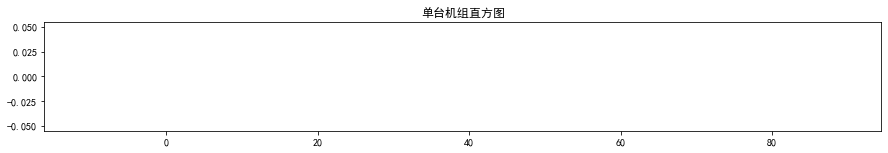

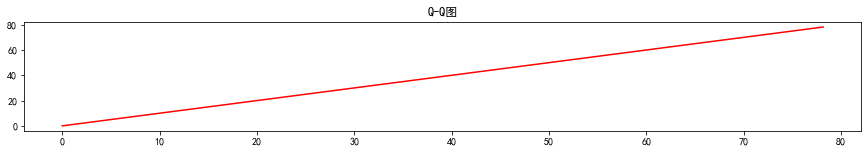

Q-Q图结果： nan


In [15]:
col='齿轮箱高速轴驱动端轴承温度'
device_list=['JN125-B501']  ### 最好不超过5台
for deviceid in device_list:
    print('\n%s %s %s'%('*'*50, deviceid, '*'*50))
    myfunc(DATA,deviceid=deviceid,col=col)


************************************************** JN125-B501 **************************************************


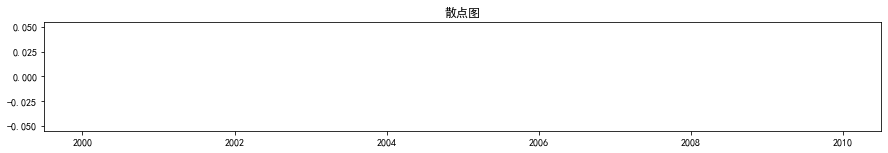

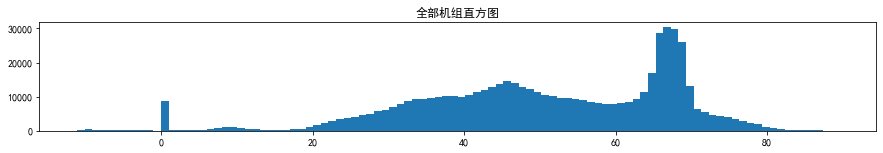

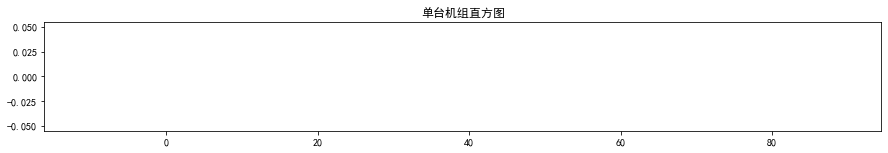

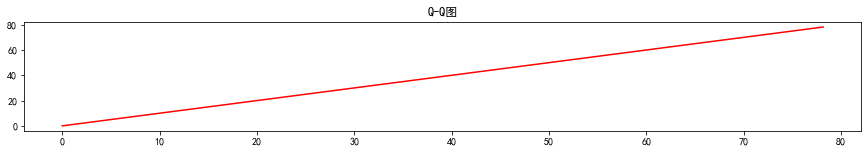

Q-Q图结果： nan


In [14]:
col='齿轮箱高速轴驱动端轴承温度'
device_list=['JN125-B501']  ### 最好不超过5台
for deviceid in device_list:
    print('\n%s %s %s'%('*'*50, deviceid, '*'*50))
    myfunc(DATA[DATA[col]<200],deviceid=deviceid,col=col)



异常变量：发电机滑环室温度

分布异常度：10.10 %


************************************************** B54-5409F **************************************************


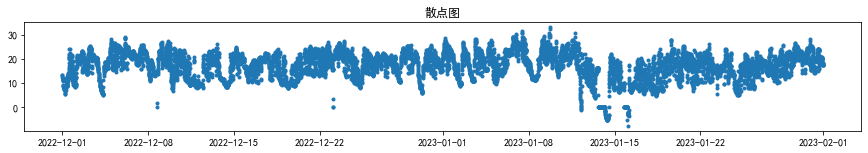

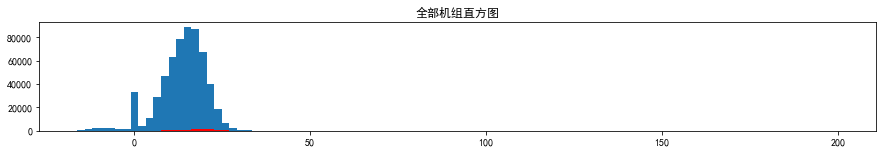

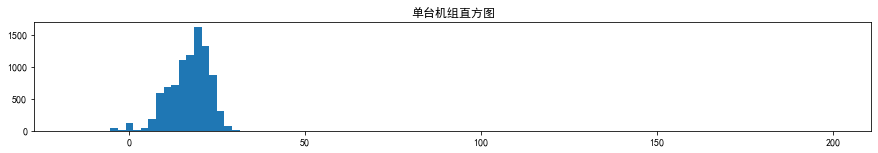

**************************************************


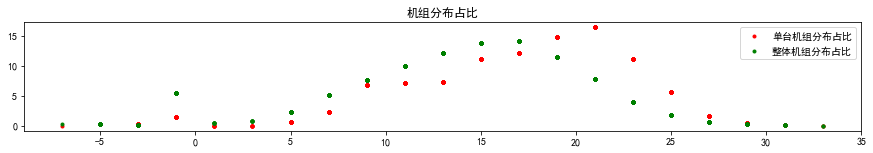

直方图结果： 4.2570868345685255


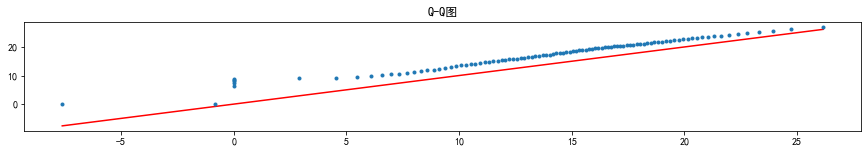

Q-Q图结果： 10.101383985505908


In [13]:
col='发电机滑环室温度'
device_list=['B54-5409F']  ### 最好不超过5台
for deviceid in device_list:
    print('\n%s %s %s'%('*'*50, deviceid, '*'*50))
    myfunc(DATA,deviceid=deviceid,col=col)

基于Q-Q图进行异常警报方法，会出现两种情况：
1. 实际数据点全部在基准线的一侧（上或下），导致累计误差高
2. 部分（甚至是大部分）数据点和基准线贴合程度较好，两端会有部分数据偏差较大

前一种情况的标准差较小，后一种情况的标准差较大。

第一种情况不应该被视为异常，不过可以做出标识






基于此，考虑的优化方向：
1. 对各个分位点做加权平均（而不是等权平均）
2. 高值过高，或低值过低，都是检测的重点；因此，权重是该分位点和0.5的距离；

对每一列计算结果，利用IQR方法计算上边界

In [72]:
result = pd.read_csv(r'E:\已开发模型批量运行\data_picture\%s\20221201_20230131\distribution_check\result.csv'%field_name)
check_cols = [col for col in result.columns if not col == 'deviceid']
for col in check_cols:
    print('*'*50)
    temp=result[col].dropna().copy()
    if not len(temp):
        continue
    q1=np.quantile(temp,0.25)
    q3=np.quantile(temp,0.75)
    iqr=q3-q1
    upper=q3+1.5*iqr
    print('变量 %s 上边界是：%.2f'%(col, upper))
    res_list=result[result[col]>upper]['deviceid'].tolist()
    print('涵盖的机组有：')
    print(res_list)
    print('\n')

**************************************************
变量 叶轮转速1 上边界是：8.28
涵盖的机组有：
['B44-5412F']


**************************************************
变量 主轴承温度1 上边界是：10.39
涵盖的机组有：
['B39-5305F', 'B45-5413F', 'B54-5409F', 'B58-5502F', 'B60-5504F', 'B67-5511F']


**************************************************
变量 叶片1实际桨距角 上边界是：8.82
涵盖的机组有：
[]


**************************************************
变量 叶片2实际桨距角 上边界是：8.83
涵盖的机组有：
[]


**************************************************
变量 叶片3实际桨距角 上边界是：8.80
涵盖的机组有：
[]


**************************************************
变量 叶片桨距角设定值 上边界是：7.79
涵盖的机组有：
['B08-5110F']


**************************************************
变量 叶片1变桨电机温度 上边界是：9.43
涵盖的机组有：
['B12-5114F', 'B34-5313F', 'B41-5307F', 'B57-5501F']


**************************************************
变量 叶片2变桨电机温度 上边界是：8.53
涵盖的机组有：
['B08-5110F', 'B29-5308F']


**************************************************
变量 叶片3变桨电机温度 上边界是：7.51
涵盖的机组有：
['B11-5113F', 'B12-5114F', 'B24-5201F', 'B42-5410F']


*****

异常机组：A35-6402F

异常变量：机舱外环境温度

分布异常度：22.67 %


************************************************** A35-6402F **************************************************


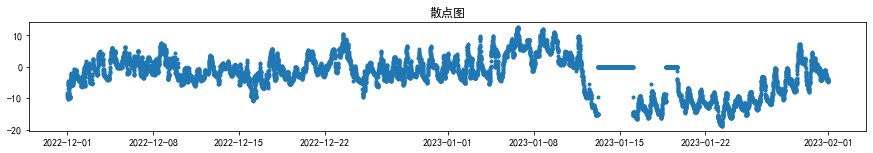

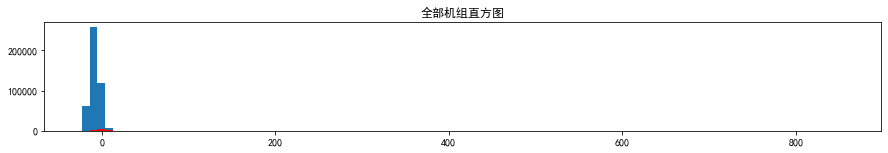

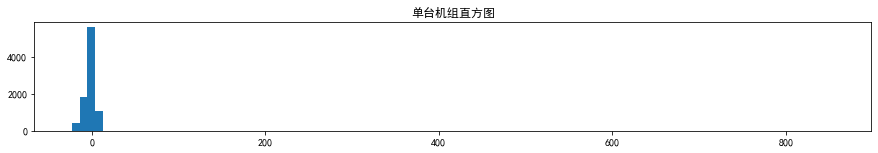

**************************************************


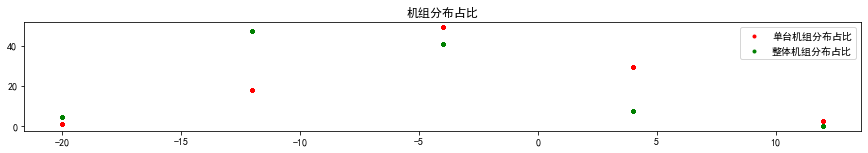

直方图结果： 16.062582883510842


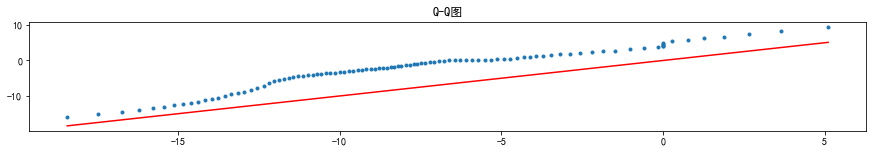

Q-Q图结果： 22.62598140459276


In [19]:
col='机舱外环境温度'
device_list=['A35-6402F']  ### 最好不超过5台
for deviceid in device_list:
    print('\n%s %s %s'%('*'*50, deviceid, '*'*50))
    myfunc(DATA,deviceid=deviceid,col=col)

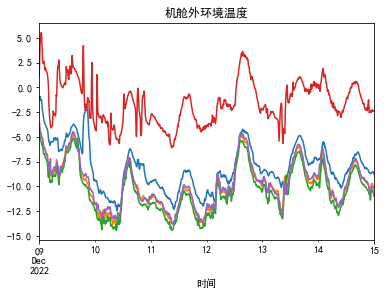

In [22]:
use_cols = ['风速1','机舱外环境温度']
starttime=pd.to_datetime('2022-12-09')
endtime=pd.to_datetime('2022-12-15')

temp_data=DATA[(DATA['deviceid'].isin(['A35-6402F','A06-6108F','A47-6505F','A21-6306F','A29-6304F']))&(DATA['时间'].between(starttime,endtime))].set_index('时间')

_=temp_data.groupby('deviceid')['机舱外环境温度'].plot(title='机舱外环境温度')

In [21]:
col='机舱外环境温度'
DATA.groupby('deviceid')[col].quantile(0.9).sort_values(ascending=False)

deviceid
A35-6402F    4.4858
A22-6307F    1.9998
A06-6108F    1.2864
A18-6202F    0.7820
A09-6101F    0.3426
A11-6205F    0.0050
A01-6103F    0.0000
A39-6406F    0.0000
A31-6408F    0.0000
A32-6409F    0.0000
A33-6410F    0.0000
A34-6401F    0.0000
A36-6403F    0.0000
A37-6404F    0.0000
A38-6405F    0.0000
A41-6509F    0.0000
A40-6407F    0.0000
A28-6303F    0.0000
A42-6510F    0.0000
A43-6501F    0.0000
A44-6502F    0.0000
A45-6503F    0.0000
A46-6504F    0.0000
A47-6505F    0.0000
A48-6506F    0.0000
A49-6507F    0.0000
A30-6305F    0.0000
A26-6301F    0.0000
A15-6209F    0.0000
A27-6302F    0.0000
A03-6105F    0.0000
A04-6106F    0.0000
A05-6107F    0.0000
A07-6109F    0.0000
A08-6110F    0.0000
A10-6102F    0.0000
A12-6206F    0.0000
A13-6207F    0.0000
A14-6208F    0.0000
A50-6508F    0.0000
A16-6210F    0.0000
A17-6201F    0.0000
A19-6203F    0.0000
A20-6204F    0.0000
A21-6306F    0.0000
A23-6308F    0.0000
A24-6309F    0.0000
A02-6104F    0.0000
A25-6310F   -0.0026
A29-6304F  

In [23]:
import seaborn as sns

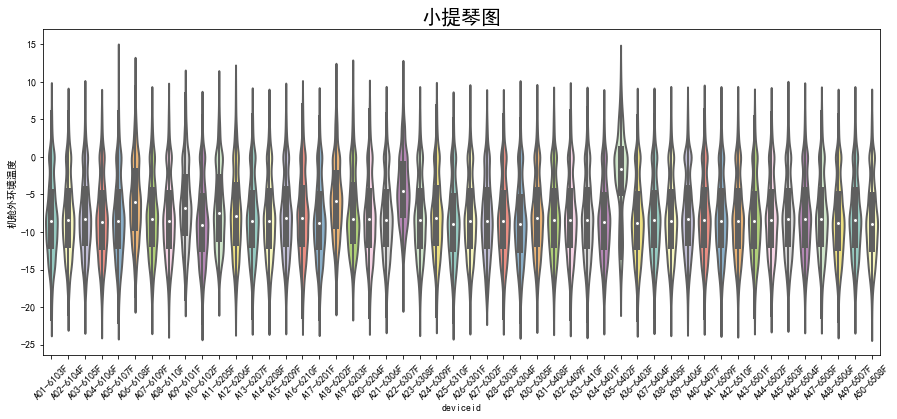

In [43]:
fig = plt.figure(figsize=(15,6))
ax=fig.gca()
sns.violinplot(data=DATA[DATA[col]<20], x='deviceid',y=col, palette="Set3", bw=.2, cut=2, linewidth=2, ax=ax)
ax.set_title('小提琴图', fontsize = 20)
ax.xaxis.set_tick_params(rotation=45)

count    8923.000000
mean       -7.974568
std         5.151272
min       -21.367000
25%       -11.653000
50%        -8.395000
75%        -4.664000
max         7.335000
Name: 机舱外环境温度, dtype: float64


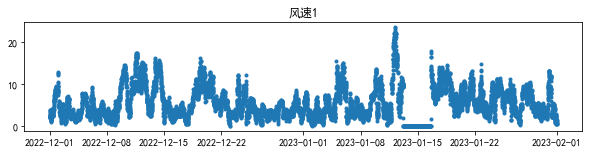

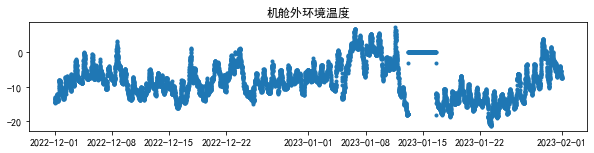

In [40]:
deviceid='A21-6306F'
check_col='机舱外环境温度'
use_cols = ['风速1','机舱外环境温度']
starttime=pd.to_datetime('2022-01-11')
endtime=pd.to_datetime('2023-02-18')
temp_data=DATA[(DATA['deviceid']==deviceid)&(DATA['时间'].between(starttime,endtime))].set_index('时间')
print(temp_data[check_col].describe())
for col in use_cols:
    plt.figure(figsize=(10,2))
    plt.plot(temp_data[col],'.')
    plt.title(col)
    plt.show()
    plt.close()

count    8923.000000
mean       -2.600370
std        51.528118
min       -18.600000
25%        -9.468000
50%        -6.032000
75%        -1.809500
max       854.600000
Name: 机舱外环境温度, dtype: float64


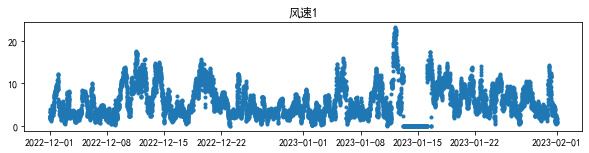

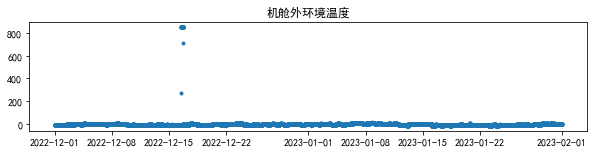

In [42]:
deviceid='A06-6108F'
check_col='机舱外环境温度'
use_cols = ['风速1','机舱外环境温度']
starttime=pd.to_datetime('2022-01-11')
endtime=pd.to_datetime('2023-02-18')
temp_data=DATA[(DATA['deviceid']==deviceid)&(DATA['时间'].between(starttime,endtime))].set_index('时间')
print(temp_data[check_col].describe())
for col in use_cols:
    plt.figure(figsize=(10,2))
    plt.plot(temp_data[col],'.')
    plt.title(col)
    plt.show()
    plt.close()

count    8923.000000
mean        6.460560
std         4.821996
min        -9.484000
25%         3.336000
50%         6.481000
75%         9.755500
max        21.132000
Name: 机舱内温度, dtype: float64


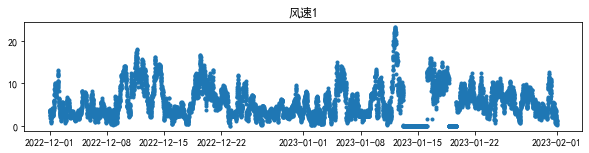

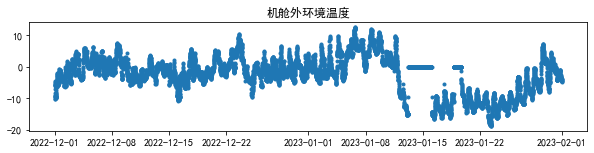

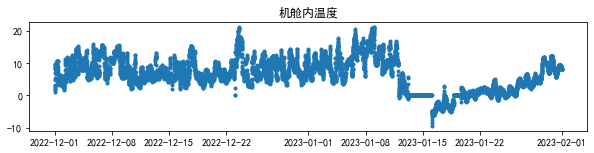

In [34]:
deviceid='A35-6402F'
check_col='机舱外环境温度'
use_cols = ['风速1','机舱外环境温度','机舱内温度']
starttime=pd.to_datetime('2022-01-11')
endtime=pd.to_datetime('2023-02-18')
temp_data=DATA[(DATA['deviceid']==deviceid)&(DATA['时间'].between(starttime,endtime))].set_index('时间')
print(temp_data[col].describe())
for col in use_cols:
    plt.figure(figsize=(10,2))
    plt.plot(temp_data[col],'.')
    plt.title(col)
    plt.show()
    plt.close()

count    8923.000000
mean        5.412676
std         4.965032
min       -14.145000
25%         1.962500
50%         5.359000
75%         8.866500
max        25.000000
Name: 机舱内温度, dtype: float64


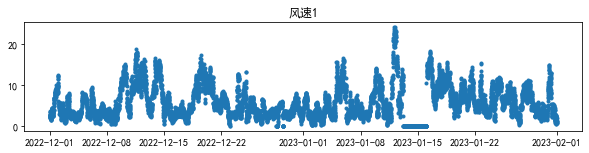

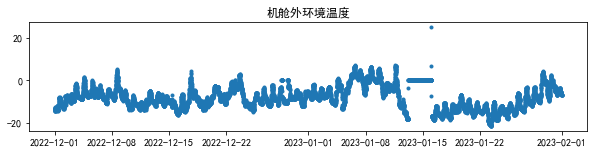

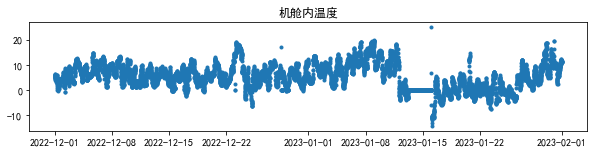

In [33]:
deviceid='A14-6208F'
check_col='机舱外环境温度'
use_cols = ['风速1','机舱外环境温度','机舱内温度']
starttime=pd.to_datetime('2022-01-11')
endtime=pd.to_datetime('2023-02-18')
temp_data=DATA[(DATA['deviceid']==deviceid)&(DATA['时间'].between(starttime,endtime))].set_index('时间')
print(temp_data[col].describe())
for col in use_cols:
    plt.figure(figsize=(10,2))
    plt.plot(temp_data[col],'.')
    plt.title(col)
    plt.show()
    plt.close()

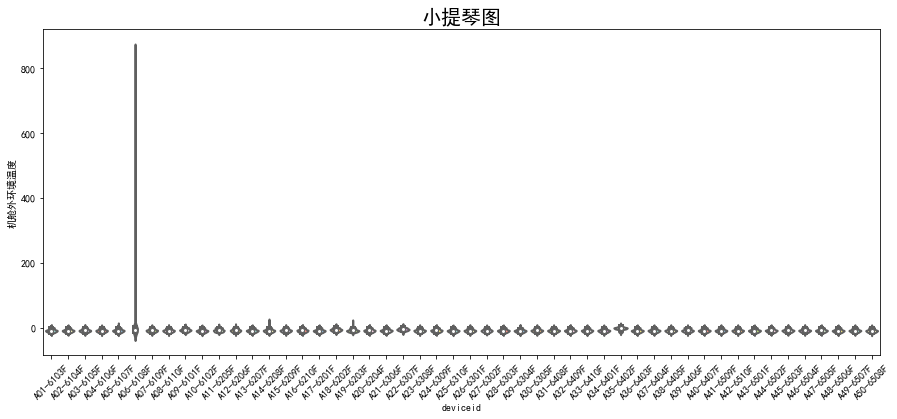

In [36]:
fig = plt.figure(figsize=(15,6))
ax=fig.gca()
sns.violinplot(data=DATA, x='deviceid',y='机舱外环境温度', palette="Set3", bw=.2, cut=2, linewidth=2, ax=ax)
ax.set_title('小提琴图', fontsize = 20)
ax.xaxis.set_tick_params(rotation=45)

In [45]:
field_name='安马四（马鬃山三期）'

In [46]:
result = pd.read_csv(r'E:\已开发模型批量运行\data_picture\%s\20221201_20230131\distribution_check\result.csv'%field_name)
check_cols = [col for col in result.columns if not col == 'deviceid']
for col in check_cols:
    print('*'*50)
    temp=result[col].dropna().copy()
    if not len(temp):
        continue
    q1=np.quantile(temp,0.25)
    q3=np.quantile(temp,0.75)
    iqr=q3-q1
    upper=q3+1.5*iqr
    print('变量 %s 上边界是：%.2f'%(col, upper))
    res_list=result[result[col]>upper]['deviceid'].tolist()
    print('涵盖的机组有：')
    print(res_list)
    print('\n')

**************************************************
变量 叶轮转速1 上边界是：4.17
涵盖的机组有：
['F01-6701F', 'F12-6A05F']


**************************************************
变量 主轴承温度1 上边界是：30.23
涵盖的机组有：
[]


**************************************************
变量 叶片1实际桨距角 上边界是：5.32
涵盖的机组有：
['F01-6701F']


**************************************************
变量 叶片2实际桨距角 上边界是：5.30
涵盖的机组有：
['F01-6701F']


**************************************************
变量 叶片3实际桨距角 上边界是：5.35
涵盖的机组有：
['F01-6701F']


**************************************************
变量 叶片平均桨距角 上边界是：5.70
涵盖的机组有：
[]


**************************************************
变量 叶片1变桨电机温度 上边界是：23.62
涵盖的机组有：
[]


**************************************************
变量 叶片2变桨电机温度 上边界是：24.56
涵盖的机组有：
[]


**************************************************
变量 叶片3变桨电机温度 上边界是：27.05
涵盖的机组有：
[]


**************************************************
变量 叶片1变桨电池（电容）温度 上边界是：11.26
涵盖的机组有：
['F11-6A04F']


**************************************************
变量 叶片2变桨电池（电容）